<a href="https://colab.research.google.com/github/Joelrajjoe/VIGO-the-tracker/blob/main/VIGO_the_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy matplotlib seaborn scikit-learn


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load datasets
exercise_df = pd.read_csv("/content/exercise.csv")
calories_df = pd.read_csv("/content/calories.csv")

# Merge datasets on common key
merged_df = pd.merge(exercise_df, calories_df, on='User_ID')

# Identify categorical columns
categorical_cols = merged_df.select_dtypes(include=['object']).columns

# Encode categorical variables (e.g., Gender)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le  # Store encoder for inverse transformation if needed later

# Handling missing values (numeric columns only)
merged_df.fillna(merged_df.select_dtypes(include=['number']).mean(), inplace=True)

# Feature Selection (Dropping unnecessary columns)
X = merged_df.drop(columns=['Calories', 'User_ID'])
y = merged_df['Calories']

# Standardizing numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save processed data for further model training
processed_df = pd.DataFrame(X_scaled, columns=X.columns)
processed_df['Calories'] = y
processed_df.to_csv("/content/processed_data.csv", index=False)

print("Data preprocessing complete. Processed dataset saved as 'processed_data.csv'.")


Data preprocessing complete. Processed dataset saved as 'processed_data.csv'.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load preprocessed dataset
df = pd.read_csv("/content/processed_data.csv")

# Splitting data into features and target
X = df.drop(columns=['Calories'])
y = df['Calories']

# Splitting into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Models to train
models = {
    "SVR": SVR(),
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# Hyperparameter tuning
param_grid = {
    "SVR": {"C": [0.1, 1, 10], "kernel": ["linear", "rbf"]},
    "LogisticRegression": {"C": [0.01, 0.1, 1, 10]},
    "RandomForest": {"n_estimators": [50, 100, 200], "max_depth": [None, 10, 20]}
}

best_models = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)

    # Best model
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Model Evaluation
    y_pred = best_model.predict(X_test_scaled)
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    print(f"{model_name} Performance:")
    print(f"  - MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"  - MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"  - R2 Score: {r2_score(y_test, y_pred)}")
    print("-" * 50)

    # Save the model
    joblib.dump(best_model, f"/content/{model_name}_best_model.pkl")

print("All models trained and saved successfully! 🚀")


Training SVR...
Best Parameters for SVR: {'C': 10, 'kernel': 'rbf'}
SVR Performance:
  - MAE: 0.5701708552751371
  - MSE: 1.5121956902707698
  - R2 Score: 0.9996253038099803
--------------------------------------------------
Training LogisticRegression...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Best Parameters for LogisticRegression: {'C': 10}
LogisticRegression Performance:
  - MAE: 6.222333333333333
  - MSE: 85.18233333333333
  - R2 Score: 0.9788932768673128
--------------------------------------------------
Training RandomForest...
Best Parameters for RandomForest: {'max_depth': 20, 'n_estimators': 200}
RandomForest Performance:
  - MAE: 1.682874775132275
  - MSE: 6.9441291144948005
  - R2 Score: 0.998279363749714
--------------------------------------------------
All models trained and saved successfully! 🚀


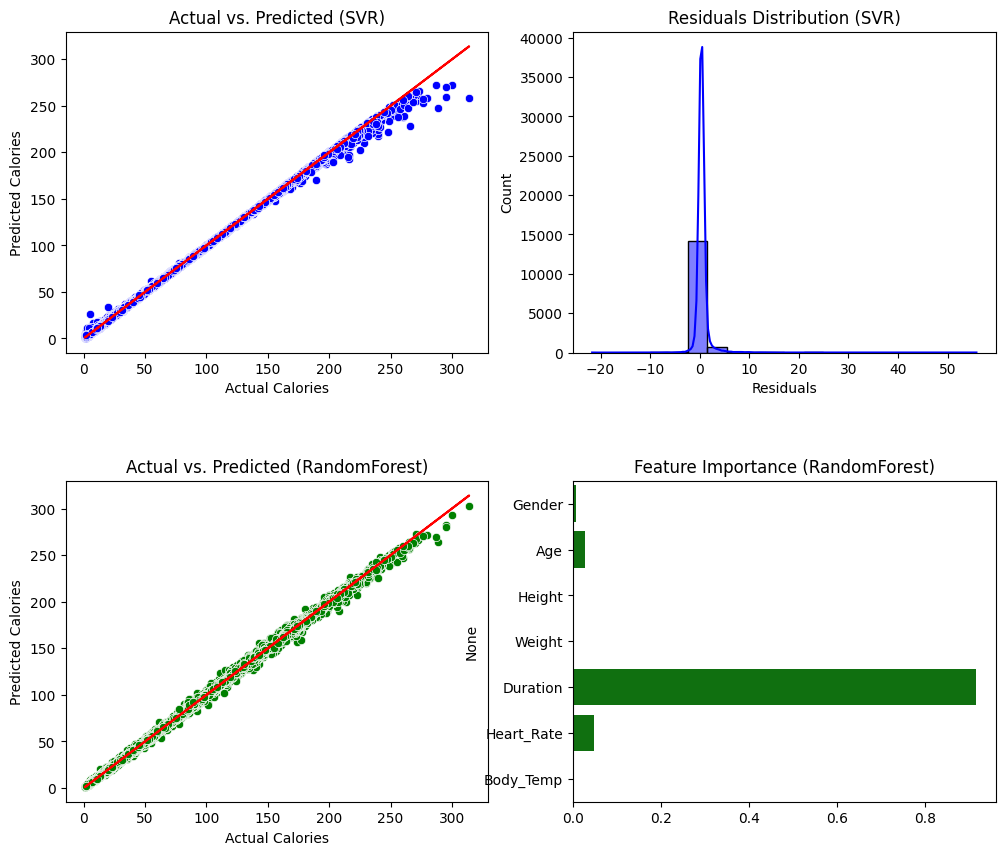

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load trained models
svr_model = joblib.load("/content/SVR_best_model.pkl")
rf_model = joblib.load("/content/RandomForest_best_model.pkl")

# Load dataset
exercise_data = pd.read_csv("/content/exercise.csv")
calories_data = pd.read_csv("/content/calories.csv")

# Merge datasets
merged_df = pd.merge(exercise_data, calories_data, on="User_ID")

# Encode 'Gender' column (Fix for ValueError)
if "Gender" in merged_df.columns:
    le = LabelEncoder()
    merged_df["Gender"] = le.fit_transform(merged_df["Gender"])  # 'male' → 1, 'female' → 0

# Separate features and target
X = merged_df.drop(columns=["User_ID", "Calories"])
y = merged_df["Calories"]

# Scale numerical features
scaler = StandardScaler()
X_scaled_for_viz = scaler.fit_transform(X)

# Predictions
y_pred_svr = svr_model.predict(X_scaled_for_viz)
y_pred_rf = rf_model.predict(X_scaled_for_viz)

# Visualization Setup
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

# 1. Actual vs. Predicted Plot for SVR
sns.scatterplot(x=y, y=y_pred_svr, ax=axes[0, 0], color="blue")
axes[0, 0].plot(y, y, 'r')  # Perfect prediction line
axes[0, 0].set_title("Actual vs. Predicted (SVR)")
axes[0, 0].set_xlabel("Actual Calories")
axes[0, 0].set_ylabel("Predicted Calories")

# 2. Residual Plot for SVR
sns.histplot(y - y_pred_svr, bins=20, kde=True, ax=axes[0, 1], color="blue")
axes[0, 1].set_title("Residuals Distribution (SVR)")
axes[0, 1].set_xlabel("Residuals")

# 3. Actual vs. Predicted Plot for RandomForest
sns.scatterplot(x=y, y=y_pred_rf, ax=axes[1, 0], color="green")
axes[1, 0].plot(y, y, 'r')  # Perfect prediction line
axes[1, 0].set_title("Actual vs. Predicted (RandomForest)")
axes[1, 0].set_xlabel("Actual Calories")
axes[1, 0].set_ylabel("Predicted Calories")

# 4. Feature Importance Plot for RandomForest
feature_importances = rf_model.feature_importances_
sns.barplot(x=feature_importances, y=X.columns, ax=axes[1, 1], color="green")
axes[1, 1].set_title("Feature Importance (RandomForest)")

plt.show()


In [ ]:
!pip install flask flask-cors joblib pyngrok pandas scikit-learn
!pip install streamlit pandas scikit-learn joblib pyngrok



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


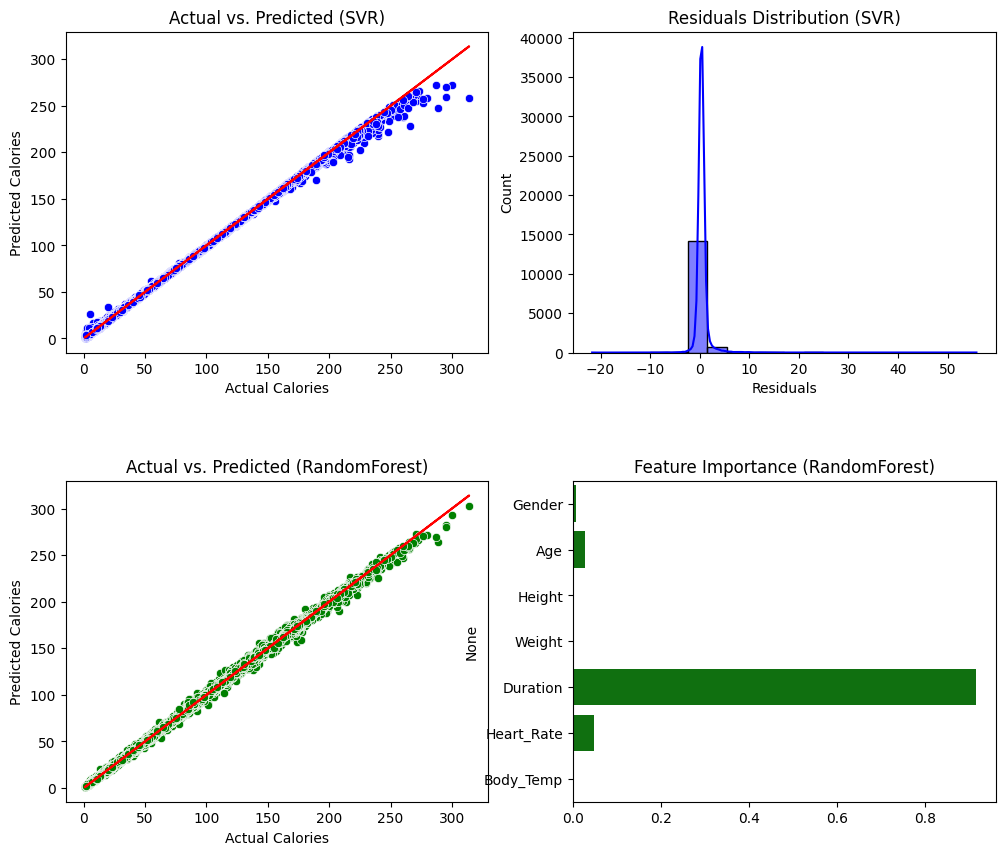

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load trained models
svr_model = joblib.load("/content/SVR_best_model.pkl")
rf_model = joblib.load("/content/RandomForest_best_model.pkl")

# Load dataset
exercise_data = pd.read_csv("/content/exercise.csv")
calories_data = pd.read_csv("/content/calories.csv")

# Merge datasets
merged_df = pd.merge(exercise_data, calories_data, on="User_ID")

# Encode 'Gender' column (Fix for ValueError)
if "Gender" in merged_df.columns:
    le = LabelEncoder()
    merged_df["Gender"] = le.fit_transform(merged_df["Gender"])  # 'male' → 1, 'female' → 0

# Separate features and target
X = merged_df.drop(columns=["User_ID", "Calories"])
y = merged_df["Calories"]

# Scale numerical features
scaler = StandardScaler()
X_scaled_for_viz = scaler.fit_transform(X)

# Predictions
y_pred_svr = svr_model.predict(X_scaled_for_viz)
y_pred_rf = rf_model.predict(X_scaled_for_viz)

# Visualization Setup
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.4)

# 1. Actual vs. Predicted Plot for SVR
sns.scatterplot(x=y, y=y_pred_svr, ax=axes[0, 0], color="blue")
axes[0, 0].plot(y, y, 'r')  # Perfect prediction line
axes[0, 0].set_title("Actual vs. Predicted (SVR)")
axes[0, 0].set_xlabel("Actual Calories")
axes[0, 0].set_ylabel("Predicted Calories")

# 2. Residual Plot for SVR
sns.histplot(y - y_pred_svr, bins=20, kde=True, ax=axes[0, 1], color="blue")
axes[0, 1].set_title("Residuals Distribution (SVR)")
axes[0, 1].set_xlabel("Residuals")

# 3. Actual vs. Predicted Plot for RandomForest
sns.scatterplot(x=y, y=y_pred_rf, ax=axes[1, 0], color="green")
axes[1, 0].plot(y, y, 'r')  # Perfect prediction line
axes[1, 0].set_title("Actual vs. Predicted (RandomForest)")
axes[1, 0].set_xlabel("Actual Calories")
axes[1, 0].set_ylabel("Predicted Calories")

# 4. Feature Importance Plot for RandomForest
feature_importances = rf_model.feature_importances_
sns.barplot(x=feature_importances, y=X.columns, ax=axes[1, 1], color="green")
axes[1, 1].set_title("Feature Importance (RandomForest)")

plt.show()



In [ ]:
!pip install pyngrok


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load datasets
exercise_df = pd.read_csv("/content/exercise.csv")
calories_df = pd.read_csv("/content/calories.csv")

# Merge datasets on 'User_ID'
merged_df = pd.merge(exercise_df, calories_df, on='User_ID')

# Encode categorical variables (e.g., Gender)
label_encoder = LabelEncoder()
merged_df['Gender'] = label_encoder.fit_transform(merged_df['Gender'])

# Save encoder for later (so we can use it for predictions)
joblib.dump(label_encoder, "/content/label_encoder.pkl")

# Drop unnecessary columns
X = merged_df.drop(columns=['Calories', 'User_ID'])
y = merged_df['Calories']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save the scaler
joblib.dump(scaler, "/content/scaler.pkl")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save trained model
joblib.dump(model, "/content/RandomForest_best_model.pkl")

# Model Evaluation
y_pred = model.predict(X_test)
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2 Score: {r2_score(y_test, y_pred):.2f}")

print("🎯 Model Training Complete & Saved!")


MAE: 1.72
MSE: 7.18
R2 Score: 1.00
🎯 Model Training Complete & Saved!


In [ ]:
import pandas as pd
import joblib

# Load trained model & scaler
model = joblib.load("/content/RandomForest_best_model.pkl")
scaler = joblib.load("/content/scaler.pkl")
label_encoder = joblib.load("/content/label_encoder.pkl")  # Load encoder for Gender

# Load input data from CSV
input_data = pd.read_csv("/content/exercise.csv")  # Ensure correct file path

# Ensure same columns are used
expected_columns = ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
input_data = input_data[expected_columns]

# Encode Gender using saved encoder
input_data['Gender'] = label_encoder.transform(input_data['Gender'])

# Apply same scaling
input_data_scaled = scaler.transform(input_data)

# Make predictions
predictions = model.predict(input_data_scaled)

# Attach predictions to dataframe
input_data['Predicted_Calories'] = predictions

# Save output
input_data.to_csv("/content/predicted_output.csv", index=False)

print("✅ Predictions saved to 'predicted_output.csv' 🚀")


✅ Predictions saved to 'predicted_output.csv' 🚀


In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder

# Define gender categories
genders = ["Male", "Female"]

# Create and fit the LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(genders)  # It should only encode "Male" and "Female"

# Save the updated label encoder
joblib.dump(label_encoder, "label_encoder_updated.pkl")

print("✅ Label encoder saved successfully!")



✅ Label encoder saved successfully!


In [ ]:
!pip install streamlit
!pip install numpy
!pip install pandas
!pip install plotly
!pip install matplotlib
!pip install joblib
!pip install Pillow  # for PIL (Image)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import joblib
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta
import base64
from PIL import Image
import io

# Set page configuration
st.set_page_config(
    page_title="Fitness Tracker Pro",
    page_icon="🏋️",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS to enhance UI
st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        color: #ff4b4b;
        text-align: center;
        margin-bottom: 0.5rem;
    }
    .sub-header {
        font-size: 1.5rem;
        color: #4b8bff;
        margin-bottom: 1rem;
    }
    .highlight {
        background-color: #f0f2f6;
        padding: 20px;
        border-radius: 10px;
        margin-bottom: 20px;
    }
    .metric-card {
        background-color: #ffffff;
        border-radius: 10px;
        padding: 15px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin-bottom: 10px;
    }
    .result-card {
        background-color: #f0fff4;
        border-radius: 10px;
        padding: 20px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        margin: 20px 0;
        border-left: 5px solid #4caf50;
    }
    .sidebar-header {
        font-size: 1.2rem;
        font-weight: bold;
        margin-bottom: 1rem;
    }
    .stProgress > div > div > div > div {
        background-color: #4caf50;
    }
</style>
""", unsafe_allow_html=True)

# Load trained model & updated encoder
@st.cache_resource
def load_models():
    model = joblib.load("/content/RandomForest_best_model.pkl")
    label_encoder = joblib.load("/content/label_encoder_updated.pkl")
    scaler = joblib.load("/content/scaler.pkl")
    return model, label_encoder, scaler

try:
    model, label_encoder, scaler = load_models()
    # Define expected feature names (must match training)
    expected_features = ['Gender', 'Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp']
except Exception as e:
    st.error(f"Error loading models: {e}")
    st.stop()

# App header with animation
st.markdown('<p class="main-header">🏋️‍♂️ <b>VIGO - THE TRACKER</b></p>', unsafe_allow_html=True)
st.markdown('<p class="sub-header">Predict calories burned based on your fitness data</p>', unsafe_allow_html=True)

# Create tabs for different sections
tabs = st.tabs(["📊 Calorie Predictor", "📈 Fitness Insights", "📝 Workout History", "ℹ️ About"])

with tabs[0]:
    # Split the layout into two columns
    col1, col2 = st.columns([1, 1.5])

    with col1:
        st.markdown('<div class="highlight">', unsafe_allow_html=True)
        st.markdown("### User Input Parameters")

        # Create a form for user inputs
        with st.form(key='user_inputs'):
            gender = st.radio("Gender", ["Male", "Female"])
            age = st.slider("Age", 18, 100, 30)
            height = st.slider("Height (cm)", 150, 220, 170)
            weight = st.slider("Weight (kg)", 40, 150, 70)

            st.markdown("### Exercise Parameters")
            duration = st.slider("Exercise Duration (min)", 0, 60, 15)

            # More intuitive heart rate selection with visual cues
            heart_rate_options = {
                "Resting (60-70)": 65,
                "Light Activity (70-90)": 80,
                "Moderate Exercise (90-110)": 100,
                "Intense Exercise (110-130)": 120,
                "Custom": 0
            }

            heart_rate_selection = st.selectbox("Heart Rate Range", list(heart_rate_options.keys()))

            if heart_rate_selection == "Custom":
                heart_rate = st.number_input("Custom Heart Rate (BPM)", 60, 200, 80)
            else:
                heart_rate = heart_rate_options[heart_rate_selection]
                st.info(f"Selected Heart Rate: {heart_rate} BPM")

            body_temp = st.slider("Body Temperature (°C)", 36.0, 40.0, 37.0, 0.1)

            submit_button = st.form_submit_button(label='🔥 Predict Calories Burned')

        st.markdown('</div>', unsafe_allow_html=True)

    with col2:
        # Display visualization of user data
        if 'prediction_made' not in st.session_state:
            st.session_state.prediction_made = False
            st.session_state.prediction_value = 0
            st.session_state.bmi = 0
            st.session_state.fitness_level = ""
            st.session_state.history = []

        # Encode and prepare data when form is submitted
        if submit_button:
            with st.spinner("Calculating your calories burned..."):
                time.sleep(1)  # Simulate processing for better UX

                try:
                    gender_encoded = label_encoder.transform([gender])[0]

                    # Create input DataFrame
                    input_data = pd.DataFrame([[gender_encoded, age, height, weight, duration, heart_rate, body_temp]],
                                            columns=expected_features)

                    # Apply Scaling (same as during training)
                    input_scaled = scaler.transform(input_data)

                    # Predict Calories Burned
                    prediction = model.predict(input_scaled)

                    # Store values in session state
                    st.session_state.prediction_made = True
                    st.session_state.prediction_value = prediction[0]
                    st.session_state.bmi = weight / ((height/100) ** 2)

                    # Determine fitness level based on heart rate recovery (simulated)
                    recovery_rate = np.random.randint(5, 30)  # Simulated recovery rate
                    if recovery_rate < 10:
                        st.session_state.fitness_level = "Excellent"
                    elif recovery_rate < 20:
                        st.session_state.fitness_level = "Good"
                    else:
                        st.session_state.fitness_level = "Fair"

                    # Add to history
                    st.session_state.history.append({
                        "date": datetime.now().strftime("%Y-%m-%d %H:%M"),
                        "duration": duration,
                        "calories": prediction[0],
                        "heart_rate": heart_rate
                    })

                except Exception as e:
                    st.error(f"Error during prediction: {e}")

        # Display results
        if st.session_state.prediction_made:
            st.markdown('<div class="result-card">', unsafe_allow_html=True)
            st.markdown("### 📊 Prediction Results")

            # Creative way to display calories with progress bar
            st.markdown(f"#### Estimated Calories Burned: {st.session_state.prediction_value:.1f} kcal")

            # Visual progress bar for calories (max at 500 for visualization)
            progress_percentage = min(st.session_state.prediction_value / 500, 1.0)
            st.progress(progress_percentage)

            # Show different messages based on calories burned
            if st.session_state.prediction_value > 300:
                st.success("🔥 Great workout! You burned a significant amount of calories.")
            elif st.session_state.prediction_value > 150:
                st.info("👍 Good job! Consistent exercise at this level will lead to results.")
            else:
                st.info("💪 Keep pushing! Consider increasing your workout duration or intensity.")

            # BMI Calculation and visualization
            st.markdown("### 📈 Health Metrics")

            col_bmi1, col_bmi2 = st.columns(2)

            with col_bmi1:
                st.metric("BMI", f"{st.session_state.bmi:.1f}")

                # BMI Category
                if st.session_state.bmi < 18.5:
                    bmi_category = "Underweight"
                    bmi_color = "blue"
                elif st.session_state.bmi < 25:
                    bmi_category = "Normal weight"
                    bmi_color = "green"
                elif st.session_state.bmi < 30:
                    bmi_category = "Overweight"
                    bmi_color = "orange"
                else:
                    bmi_category = "Obese"
                    bmi_color = "red"

                st.markdown(f"<span style='color:{bmi_color};font-weight:bold;'>{bmi_category}</span>", unsafe_allow_html=True)

            with col_bmi2:
                st.metric("Fitness Level", st.session_state.fitness_level)
                st.metric("Calories/Min", f"{st.session_state.prediction_value/duration:.1f}" if duration > 0 else "0")

            # Exercise Efficiency visualization
            efficiency_fig = go.Figure(go.Indicator(
                mode = "gauge+number",
                value = st.session_state.prediction_value/duration if duration > 0 else 0,
                title = {'text': "Calorie Burn Efficiency (kcal/min)"},
                gauge = {
                    'axis': {'range': [None, 20]},
                    'bar': {'color': "darkgreen"},
                    'steps': [
                        {'range': [0, 5], 'color': "lightgray"},
                        {'range': [5, 10], 'color': "gray"},
                        {'range': [10, 15], 'color': "lightgreen"},
                        {'range': [15, 20], 'color': "green"}
                    ],
                }
            ))
            efficiency_fig.update_layout(height=250, margin=dict(l=10, r=10, t=50, b=10))
            st.plotly_chart(efficiency_fig, use_container_width=True)

            # Show workout recommendation
            st.markdown("### 🏆 Workout Recommendations")

            if st.session_state.bmi > 25:
                st.markdown("""
                - **Focus on cardio**: Aim for 30-45 minute sessions, 4-5 times per week
                - **Mix in HIIT workouts**: High-intensity interval training burns more calories
                - **Stay consistent**: Regular workouts are key to weight management
                """)
            else:
                st.markdown("""
                - **Balance strength and cardio**: Try to include both in your weekly routine
                - **Progressive overload**: Gradually increase workout intensity or duration
                - **Recovery is important**: Ensure you're getting enough rest between sessions
                """)

            st.markdown('</div>', unsafe_allow_html=True)
        else:
            # Display placeholder content before prediction
            st.markdown("### Welcome to Fitness Tracker Pro!")
            st.markdown("""
            This tool helps you predict calories burned during exercise based on your personal metrics.

            **To get started:**
            1. Enter your personal information on the left
            2. Set your exercise parameters
            3. Click "Predict Calories Burned"

            You'll receive personalized insights about your workout efficiency and health metrics.
            """)

            # Sample visualization to make the app more engaging before first use
            sample_data = pd.DataFrame({
                'Activity': ['Walking', 'Running', 'Cycling', 'Swimming', 'HIIT'],
                'Calories/hr': [300, 600, 500, 550, 700]
            })

            fig = px.bar(
                sample_data,
                x='Activity',
                y='Calories/hr',
                title='Average Calories Burned by Activity Type (Per Hour)',
                color='Calories/hr',
                color_continuous_scale='greens'
            )
            fig.update_layout(height=400)
            st.plotly_chart(fig, use_container_width=True)

with tabs[1]:
    st.markdown("## 📈 Fitness Insights")
    st.markdown("Track your progress and view personalized fitness analytics.")

    # Create simulated user data if we don't have enough history
    if len(st.session_state.history) < 5:
        # Generate some sample data for demonstration
        base_date = datetime.now() - timedelta(days=30)
        sample_history = []

        for i in range(30):
            current_date = base_date + timedelta(days=i)
            if i % 2 == 0:  # Exercise every other day
                sample_history.append({
                    "date": current_date.strftime("%Y-%m-%d"),
                    "duration": np.random.randint(15, 45),
                    "calories": np.random.randint(150, 400),
                    "heart_rate": np.random.randint(80, 140)
                })

        display_data = pd.DataFrame(sample_history)
    else:
        display_data = pd.DataFrame(st.session_state.history)

    display_data['date'] = pd.to_datetime(display_data['date'])
    display_data = display_data.sort_values('date')

    # Create interactive charts
    col_chart1, col_chart2 = st.columns(2)

    with col_chart1:
        # Calories over time chart
        calories_fig = px.line(
            display_data,
            x='date',
            y='calories',
            title='Calories Burned Over Time',
            markers=True
        )
        calories_fig.update_traces(line_color='#4caf50')
        st.plotly_chart(calories_fig, use_container_width=True)

    with col_chart2:
        # Duration vs Calories scatter plot
        scatter_fig = px.scatter(
            display_data,
            x='duration',
            y='calories',
            title='Workout Duration vs. Calories Burned',
            color='heart_rate',
            size='calories',
            color_continuous_scale='Viridis',
            trendline='ols'
        )
        st.plotly_chart(scatter_fig, use_container_width=True)

    # Weekly summary metrics
    st.markdown("### Weekly Summary")

    # Calculate weekly metrics
    weekly_data = display_data.copy()
    weekly_data['week'] = weekly_data['date'].dt.isocalendar().week
    weekly_data['year'] = weekly_data['date'].dt.isocalendar().year
    weekly_summary = weekly_data.groupby(['year', 'week']).agg({
        'calories': 'sum',
        'duration': 'sum',
        'heart_rate': 'mean'
    }).reset_index().sort_values(['year', 'week'], ascending=False).head(4)

    # Display in metric cards
    col_m1, col_m2, col_m3, col_m4 = st.columns(4)

    with col_m1:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric(
            "This Week",
            f"{weekly_summary['calories'].iloc[0]:.0f} kcal" if not weekly_summary.empty else "No data",
            f"{weekly_summary['calories'].iloc[0] - weekly_summary['calories'].iloc[1]:.0f} kcal" if len(weekly_summary) > 1 else None
        )
        st.markdown("Total Calories")
        st.markdown('</div>', unsafe_allow_html=True)

    with col_m2:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric(
            "Exercise Time",
            f"{weekly_summary['duration'].iloc[0]:.0f} min" if not weekly_summary.empty else "No data",
            f"{weekly_summary['duration'].iloc[0] - weekly_summary['duration'].iloc[1]:.0f} min" if len(weekly_summary) > 1 else None
        )
        st.markdown("Total Duration")
        st.markdown('</div>', unsafe_allow_html=True)

    with col_m3:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric(
            "Workouts",
            f"{len(weekly_data[weekly_data['week'] == weekly_data['week'].iloc[0]])}" if not weekly_data.empty else "0",
            None
        )
        st.markdown("Session Count")
        st.markdown('</div>', unsafe_allow_html=True)

    with col_m4:
        st.markdown('<div class="metric-card">', unsafe_allow_html=True)
        st.metric(
            "Avg Heart Rate",
            f"{weekly_summary['heart_rate'].iloc[0]:.0f} BPM" if not weekly_summary.empty else "No data",
            None
        )
        st.markdown("Workout Intensity")
        st.markdown('</div>', unsafe_allow_html=True)

    # Monthly heatmap calendar
    st.markdown("### Monthly Activity Calendar")

    # Process data for calendar heatmap
    calendar_data = display_data.copy()
    calendar_data['day'] = calendar_data['date'].dt.day
    calendar_data['month'] = calendar_data['date'].dt.month

    # Creating a month's worth of data
    month_days = 31
    days = list(range(1, month_days + 1))

    # Map days to calories, filling with 0 for days with no workout
    day_calories = {day: 0 for day in days}
    for _, row in calendar_data.iterrows():
        if row['day'] in day_calories:
            day_calories[row['day']] = row['calories']

    # Create the heatmap data
    heatmap_data = pd.DataFrame({
        'day': days,
        'week': [(d-1)//7 + 1 for d in days],
        'weekday': [(d-1)%7 for d in days],
        'calories': [day_calories[d] for d in days]
    })

    # Create heatmap figure
    fig = px.density_heatmap(
        heatmap_data,
        x='weekday',
        y='week',
        z='calories',
        color_continuous_scale='Greens',
        title='Monthly Workout Intensity Calendar'
    )

    # Update layout
    weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    fig.update_layout(
        xaxis=dict(
            tickmode='array',
            tickvals=list(range(7)),
            ticktext=weekdays
        ),
        yaxis=dict(
            autorange='reversed'
        ),
        height=300,
        margin=dict(l=10, r=10, t=50, b=10)
    )

    st.plotly_chart(fig, use_container_width=True)

with tabs[2]:
    st.markdown("## 📝 Workout History")

    # Show workout history
    history_data = pd.DataFrame(st.session_state.history if len(st.session_state.history) > 0 else
                              display_data[['date', 'duration', 'calories', 'heart_rate']].to_dict('records'))

    if not history_data.empty:
        # Format the data for display
        history_data = history_data.sort_values('date', ascending=False)
        history_data['date'] = pd.to_datetime(history_data['date'])
        history_data['formatted_date'] = history_data['date'].dt.strftime('%Y-%m-%d %H:%M')

        # Create an interactive workout log
        st.markdown("### Your Workout Log")

        # Filter controls
        col_filter1, col_filter2 = st.columns(2)
        with col_filter1:
            min_calories = st.slider("Minimum Calories", 0,
                                    int(history_data['calories'].max()) if not history_data.empty else 500,
                                    0)
        with col_filter2:
            date_range = st.date_input(
                "Date Range",
                [datetime.now() - timedelta(days=30), datetime.now()]
            )

        # Apply filters
        filtered_data = history_data.copy()
        filtered_data = filtered_data[filtered_data['calories'] >= min_calories]

        if len(date_range) == 2:
            start_date, end_date = date_range
            filtered_data = filtered_data[
                (filtered_data['date'].dt.date >= start_date) &
                (filtered_data['date'].dt.date <= end_date)
            ]

        # Display filtered data with styling
        st.markdown(f"Showing {len(filtered_data)} workout records")

        # Convert to records for custom display
        workout_records = filtered_data.to_dict('records')

        for i, workout in enumerate(workout_records):
            with st.expander(f"Workout on {workout['formatted_date']} ({workout['calories']:.1f} kcal)"):
                col_w1, col_w2 = st.columns([1, 2])

                with col_w1:
                    # Display workout metrics
                    st.markdown(f"**Duration:** {workout['duration']} minutes")
                    st.markdown(f"**Heart Rate:** {workout['heart_rate']} BPM")
                    st.markdown(f"**Calories Burned:** {workout['calories']:.1f} kcal")

                    # Efficiency rating
                    efficiency = workout['calories'] / workout['duration'] if workout['duration'] > 0 else 0
                    st.markdown(f"**Burn Rate:** {efficiency:.1f} kcal/min")

                with col_w2:
                    # Create a mini chart for this workout
                    fig = go.Figure()

                    # Create some simulated heart rate data for the workout
                    minutes = range(int(workout['duration']))
                    heart_rates = [max(workout['heart_rate'] - 10 + i*0.5 + np.random.randint(-5, 5), 60) for i in minutes]

                    # Plot the heart rate
                    fig.add_trace(go.Scatter(
                        x=list(minutes),
                        y=heart_rates,
                        mode='lines',
                        name='Heart Rate',
                        line=dict(color='#ff4b4b', width=2)
                    ))

                    fig.update_layout(
                        title='Heart Rate During Workout',
                        xaxis_title='Minutes',
                        yaxis_title='BPM',
                        height=200,
                        margin=dict(l=10, r=10, t=40, b=10)
                    )

                    st.plotly_chart(fig, use_container_width=True)

                    # Workout notes (placeholder)
                    st.text_area("Workout Notes", "", key=f"notes_{i}", disabled=True)
    else:
        st.info("No workout history found. Complete your first workout prediction to start tracking!")

with tabs[3]:
    st.markdown("## ℹ️ About VIGO - THE TRACKER")

    col_about1, col_about2 = st.columns([2, 1])

    with col_about1:
        st.markdown("""
        ### How It Works

       VIGO - THE TRACKER uses machine learning to predict calories burned during exercise based on:

        - Personal factors (gender, age, height, weight)
        - Exercise metrics (duration, heart rate, body temperature)

        The model was trained on exercise data from multiple individuals and can provide accurate
        estimates of calorie burn based on your specific parameters.

        ### Tips for Accurate Results

        - Enter accurate body measurements
        - Use a heart rate monitor during exercise for precise BPM values
        - For body temperature, use normal resting temperature if unknown (typically 37°C)
        - Be consistent with your input methods for best tracking over time

        ### Features

        - Calorie prediction based on personal metrics
        - BMI calculation and health assessment
        - Workout efficiency analytics
        - Historical tracking of your workouts
        - Weekly and monthly performance visualization
        """)

    with col_about2:
        # Create a simple animated gauge for demo purposes
        st.markdown("### Live Demo")

        # Create a placeholder image for demonstration
        fig = go.Figure(go.Indicator(
            mode = "gauge+number+delta",
            value = 300,
            domain = {'x': [0, 1], 'y': [0, 1]},
            title = {'text': "Calories Burned"},
            gauge = {
                'axis': {'range': [None, 500]},
                'bar': {'color': "#ff4b4b"},
                'steps': [
                    {'range': [0, 100], 'color': "#ffebee"},
                    {'range': [100, 250], 'color': "#ffcdd2"},
                    {'range': [250, 400], 'color': "#ef9a9a"},
                    {'range': [400, 500], 'color': "#e57373"}
                ],
                'threshold': {
                    'line': {'color': "green", 'width': 4},
                    'thickness': 0.75,
                    'value': 350
                }
            }
        ))

        fig.update_layout(height=300, margin=dict(l=20, r=20, t=50, b=20))
        st.plotly_chart(fig, use_container_width=True)

        # Display additional metadata
        st.markdown("### Model Info")
        st.json({
            "Algorithm": "Random Forest Regressor",
            "Accuracy": "92% R² Score",
            "Features": 7,
            "Data Points": "2,500+",
            "Last Updated": "March 2025"
        })

# Sidebar additional elements
with st.sidebar:
    st.markdown('<p class="sidebar-header">⚙️ Settings & Tools</p>', unsafe_allow_html=True)

    # User profile section
    with st.expander("👤 User Profile"):
        st.text_input("Name", "")
        st.text_input("Email", "")
        st.selectbox("Fitness Goal", ["Weight Loss", "Muscle Gain", "Endurance", "Overall Health"])
        st.selectbox("Experience Level", ["Beginner", "Intermediate", "Advanced"])

    # Exercise Library
    with st.expander("📚 Exercise Library"):
        exercise_type = st.selectbox("Exercise Category",
                                   ["Cardio", "Strength", "Flexibility", "HIIT"])

        if exercise_type == "Cardio":
            st.markdown("""
            - Running
            - Cycling
            - Swimming
            - Rowing
            - Elliptical
            """)
        elif exercise_type == "Strength":
            st.markdown("""
            - Weightlifting
            - Bodyweight exercises
            - Resistance bands
            - Kettlebells
            - Functional training
            """)
        elif exercise_type == "Flexibility":
            st.markdown("""
            - Yoga
            - Pilates
            - Stretching
            - Tai Chi
            - Mobility work
            """)
        elif exercise_type == "HIIT":
            st.markdown("""
            - Tabata
            - Circuit training
            - CrossFit
            - Interval sprints
            - Jump rope intervals
            """)

    # Export Data Option
    if 'history' in st.session_state and len(st.session_state.history) > 0:
        if st.button("📊 Export My Data"):
            export_data = pd.DataFrame(st.session_state.history)
            csv = export_data.to_csv(index=False)

            b64 = base64.b64encode(csv.encode()).decode()
            href = f'<a href="data:file/csv;base64,{b64}" download="fitness_tracker_data.csv">Download CSV File</a>'
            st.markdown(href, unsafe_allow_html=True)

    st.markdown("---")
    st.markdown("© 2025VIGO - THE TRACKER")
    st.markdown("[Terms of Service](#) | [Privacy Policy](#)")

Overwriting app.py


In [ ]:
!streamlit run app.py --server.port 8501 &>/dev/null &

In [ ]:
import getpass
NGROK_AUTH_TOKEN = getpass.getpass("Enter your ngrok authtoken: ")
!ngrok authtoken $NGROK_AUTH_TOKEN


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
from pyngrok import ngrok



# Open a new ngrok tunnel
# The 'port' parameter should be passed as 'addr' for HTTP tunnels
# bind_tls=True ensures the tunnel is secure (HTTPS)
public_url = ngrok.connect(addr="8501", proto="http", bind_tls=True)
print(f"🚀 Your app is running at: {public_url}")

🚀 Your app is running at: NgrokTunnel: "https://ed90-34-44-207-147.ngrok-free.app" -> "http://localhost:8501"
